<a href="https://colab.research.google.com/github/nhocsukiem/xceptionDogs/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.1 MB 7.5 MB/s 
     |████████████████████████████████| 84 kB 4.5 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 112 kB 64.8 MB/s 
     |████████████████████████████████| 275 kB 75.9 MB/s 
     |████████████████████████████████| 2.3 MB 60.8 MB/s 
     |████████████████████████████████| 212 kB 72.1 MB/s 
     |████████████████████████████████| 54 kB 4.1 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 57 kB 5.5 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
     |████████████████████████████████| 80 kB 11.8 MB/s 
     |████████████████████████████████| 68 kB 8.4 MB/s 
     |████████████████████████████████| 43 kB 2.7 MB/s 
     |████████████████████████████████| 856 kB 75.6 MB/s 
     |████████████████████████████████| 594 kB 73

In [3]:
! pip install keras-tuner --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 7.4 MB/s 
     |████████████████████████████████| 1.6 MB 49.1 MB/s 


#cài những thư viện cần thiết

In [4]:
# Import libraries
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import timeit
import cv2 as cv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K
import kerastuner as kt
from keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

import gradio as gr


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [5]:
warnings.filterwarnings('ignore')

In [6]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#Tiền Xử lý ảnh

In [7]:
# Define path to data
images_dir = '/content/drive/MyDrive/MachineLearning/archive'

In [8]:
# Count the number of classes (dogs breeds)
breed_list = os.listdir(images_dir)
print("Number of breeds in dataset:", (len(breed_list)))

Number of breeds in dataset: 20


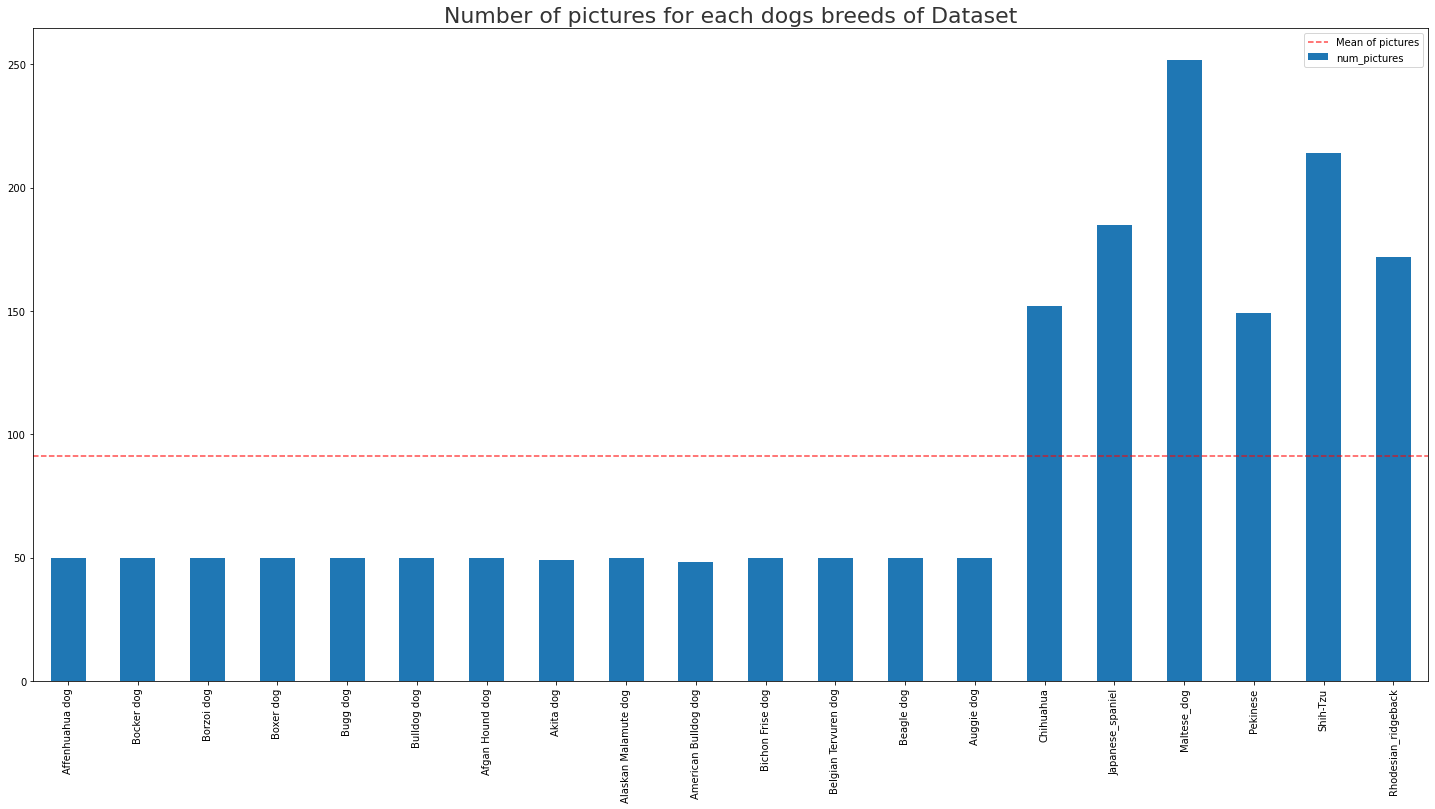

In [9]:
# Count number of pictures for each breed
df_breeds = pd.DataFrame(
    index=[breed.split('-',1)[1]
           for breed in breed_list],
    data=[len(os.listdir(images_dir + "/" + name))
          for name in breed_list],
    columns=["num_pictures"])

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(25,12))
df_breeds.plot(kind="bar",
               legend=False,
               ax=ax)
ax.axhline(df_breeds["num_pictures"].mean(),
           color='r', alpha=.7,
           linestyle='--',
           label="Mean of pictures")
plt.title("Number of pictures for each "\
          "dogs breeds of Dataset",
          color="#343434", fontsize=22)
plt.legend()
plt.show()

In [10]:
def show_images_classes(path, classes, num_sample):
    """This function is used to display the first 
    n images of a directory passed as an argument. 
    It is adapted to subdirectories. 
    
    The matplotlib.image library must be loaded 
    with the alias mpimg. 

    Parameters
    ----------------------------------------
    path : string
        Link of root directory
    classes : string 
        Name of the subdirectory
    num_smaple : integer
        Number of picture to show
    ----------------------------------------
    """
    fig = plt.figure(figsize=(20,20))
    fig.patch.set_facecolor('#343434')
    plt.suptitle("{}".format(classes.split("-")[1]), y=.83,
                 color="white", fontsize=22)
    images = os.listdir(path + "/" + classes)[:num_sample]
    for i in range(num_sample):
        img = mpimg.imread(path+"/"+classes+"/"+images[i])
        plt.subplot(num_sample/5+1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

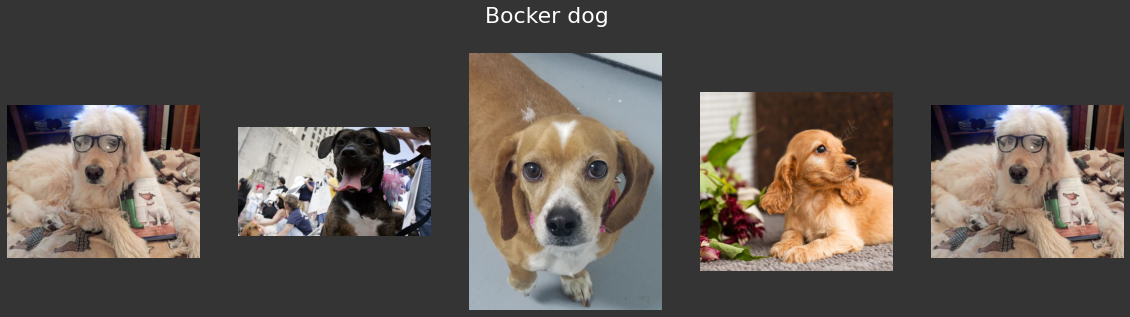

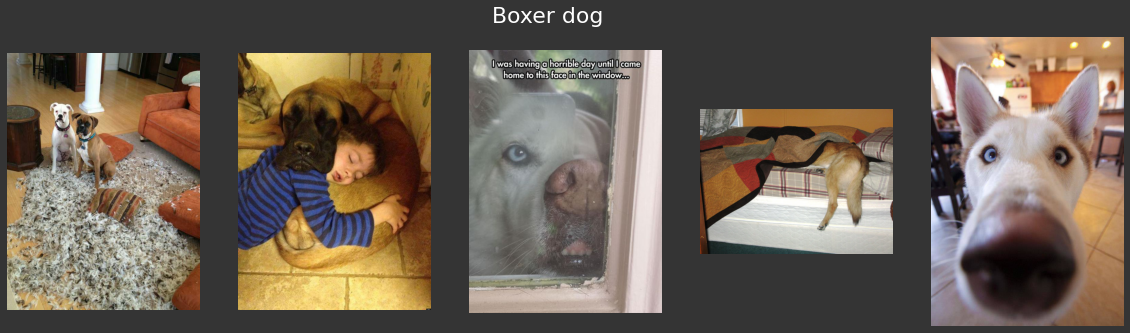

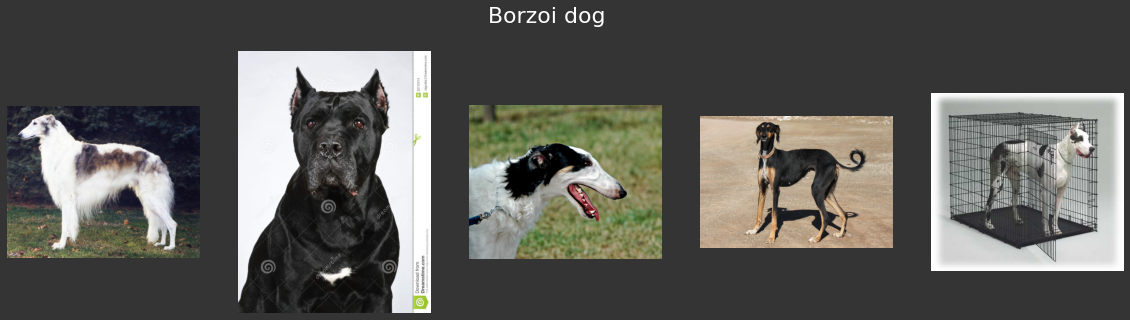

In [11]:
for i in np.random.randint(0, len(breed_list), size=3):
    show_images_classes(images_dir, breed_list[i], 5)

#Thay đổi kích thước của hình ảnh

In [12]:
# Define test image
img_test = (images_dir 
            + "/" 
            + "n14-Bulldog dog/Image_1.jpg")
img_test = cv.imread(img_test)

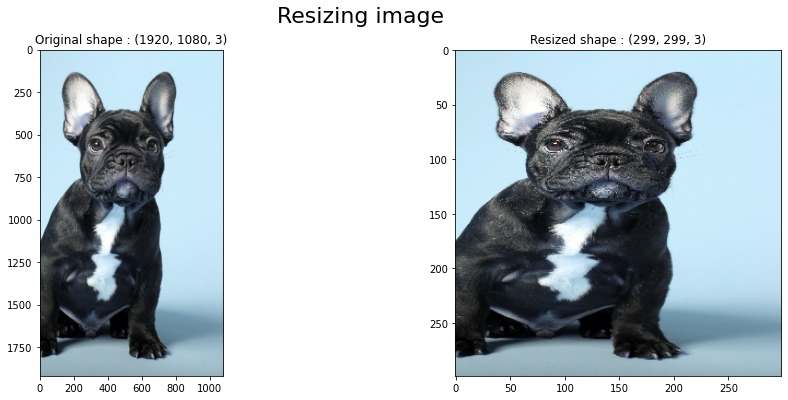

In [13]:
# setting dim of the resize
height = 299
width = 299
dim = (width, height)
# resize image with OpenCV
res_img = cv.resize(img_test, dim, interpolation=cv.INTER_LINEAR)

# Show both img
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(img_test)
plt.title("Original shape : {}".format(img_test.shape))
plt.subplot(1, 2, 2)
plt.imshow(res_img)
plt.title("Resized shape : {}".format(res_img.shape))
plt.suptitle("Resizing image",
             color="black", 
             fontsize=22, y=.98)
plt.show()

# Thay đổi Biểu đồ Hình ảnh

In [14]:
# Transform image with differents color sets
img_RGB = cv.cvtColor(img_test, cv.COLOR_BGR2RGB)
img_grayscale = cv.cvtColor(img_test, cv.COLOR_RGB2GRAY)
img_YUV = cv.cvtColor(img_test,cv.COLOR_BGR2YUV)

In [15]:
# Create histogram
def plot_histogram(init_img, convert_img):
    """Function allowing to display the initial
    and converted images according to a certain
    colorimetric format as well as the histogram
    of the latter. 

    Parameters
    -------------------------------------------
    init_img : list
        init_img[0] = Tiêu đề của hình ảnh 
        init_img[1] = Init openCV image
    convert_img : list
        convert_img[0] = Tiêu đề của chuyển đổi
        convert_img[1] = converted openCV image
    -------------------------------------------
    """
    hist, bins = np.histogram(
                    convert_img[1].flatten(),
                    256, [0,256])
    # Cumulative Distribution Function
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()

    # Plot histogram
    fig = plt.figure(figsize=(25,6))
    plt.subplot(1, 3, 1)
    plt.imshow(init_img[1])
    plt.title("{} Image".format(init_img[0]), 
              color="#343434")
    plt.subplot(1, 3, 2)
    plt.imshow(convert_img[1])
    plt.title("{} Image".format(convert_img[0]), 
              color="#343434")
    plt.subplot(1, 3, 3)
    plt.plot(cdf_normalized, 
             color='r', alpha=.7,
             linestyle='--')
    plt.hist(convert_img[1].flatten(),256,[0,256])
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.title("Histogram of convert image", color="#343434")
    plt.suptitle("Histogram and cumulative "\
                 "distribution for test image",
              color="black", fontsize=22, y=.98)
    plt.show()

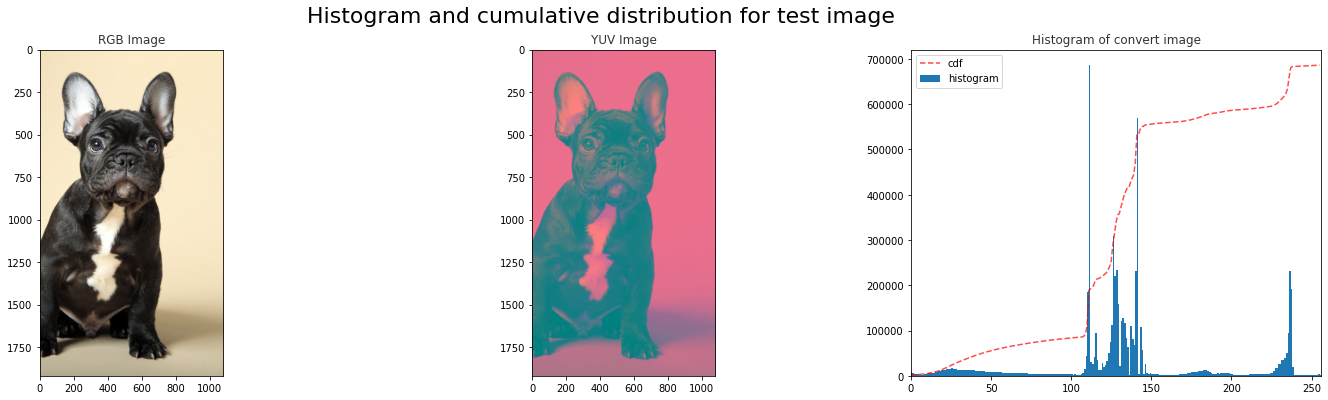

In [16]:
plot_histogram(["RGB", img_RGB], ["YUV", img_YUV])

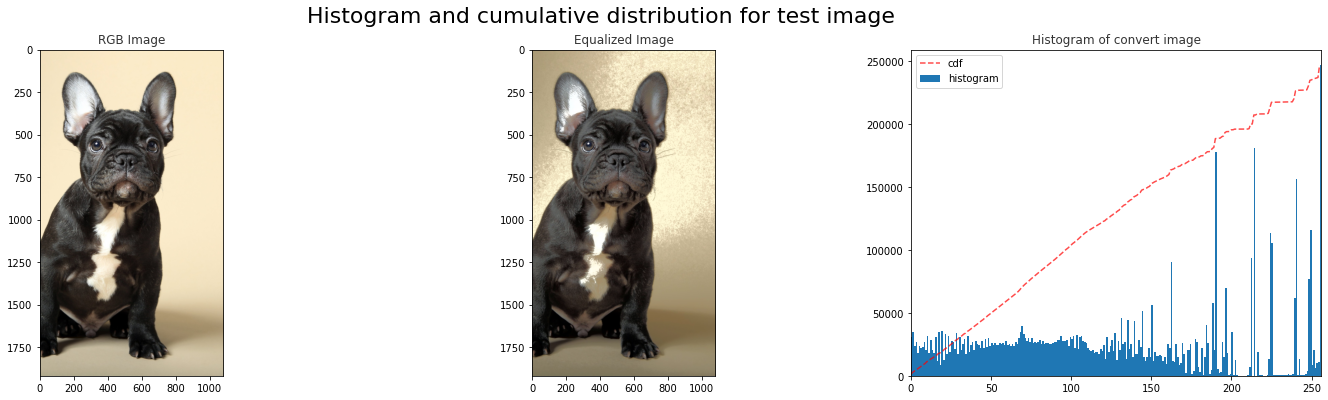

In [17]:
# Equalization
img_YUV[:,:,0] = cv.equalizeHist(img_YUV[:,:,0])
img_equ = cv.cvtColor(img_YUV, cv.COLOR_YUV2RGB)
plot_histogram(["RGB", img_RGB], ["Equalized", img_equ])

# Áp dụng bộ lọc


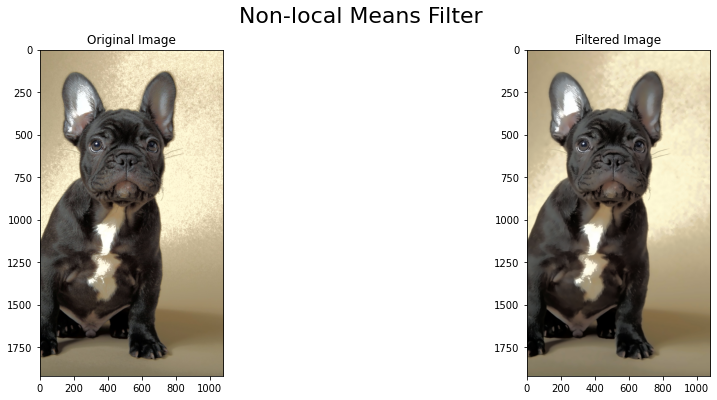

In [18]:
# Apply non-local means filter on test img
dst_img = cv.fastNlMeansDenoisingColored(
    src=img_equ,
    dst=None,
    h=10,
    hColor=10,
    templateWindowSize=7,
    searchWindowSize=21)

# Show both img
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(img_equ)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(dst_img)
plt.title("Filtered Image")
plt.suptitle("Non-local Means Filter",
             color="black", 
             fontsize=22, y=.98)
plt.show()

#Tăng cường dữ liệu ảnh

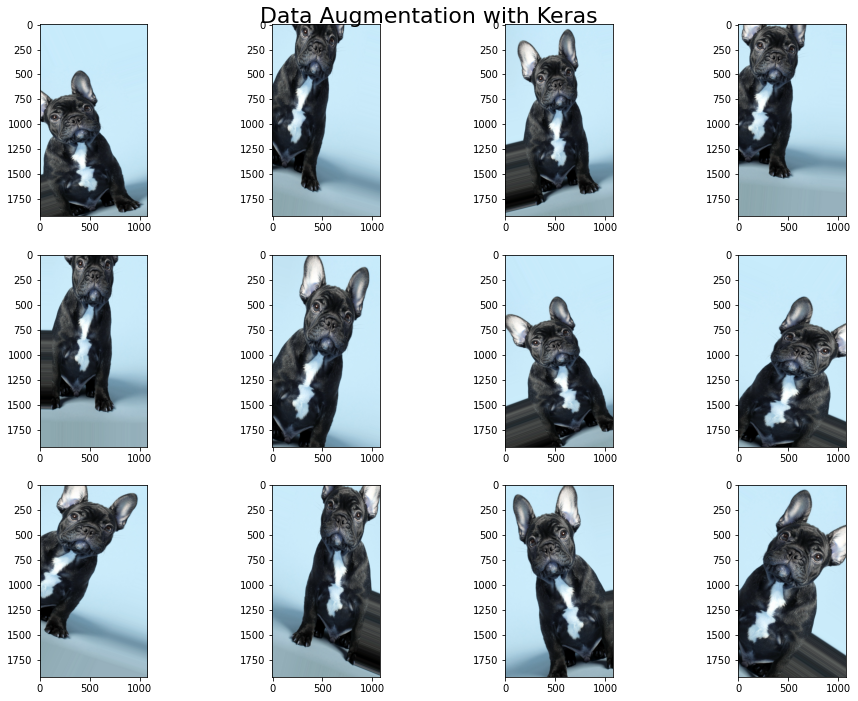

In [19]:
#Initilize Data Generator Keras
augmented_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Convert test img to array
x = image.img_to_array(img_test)
x = x.reshape((1,) + x.shape)

i=0
fig = plt.figure(figsize=(16,12))
for batch in augmented_datagen.flow(x, batch_size=1):
    ax = fig.add_subplot(3,4,i+1)
    ax.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 12 == 0:
        break

plt.suptitle("Data Augmentation with Keras",
             color="black", 
             fontsize=22, y=.90)
plt.show()

#Các chức năng trước khi xử lý ảnh

In [20]:
def preprocessing_cnn(directories, img_width, img_height):
    """Preprocessing of images in order to integrate them 
    into a convolutional neural network. Equalization, 
    Denoising and transformation of the image into Array. 
    Simultaneous creation of labels (y). 

    Parameters
    ---------------------------------------------------
    directoriesList : list
        List of files to be processed.
    img_width : integer
        width of the image to be reached for resizing
    img_height : integer
        height of the image to be reached for resizing
    ---------------------------------------------------
    """
    img_list=[]
    labels=[]
    for index, breed in enumerate(directories):
        for image_name in os.listdir(images_dir+"/"+breed):
            # Read image
            img = cv.imread(images_dir+"/"+breed+"/"+image_name)
            img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
            # Resize image
            dim = (img_width, img_height)
            img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
            # Equalization
            img_yuv = cv.cvtColor(img,cv.COLOR_BGR2YUV)
            img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
            img_equ = cv.cvtColor(img_yuv, cv.COLOR_YUV2RGB)
            # Apply non-local means filter on test img
            dst_img = cv.fastNlMeansDenoisingColored(
                src=img_equ,
                dst=None,
                h=10,
                hColor=10,
                templateWindowSize=7,
                searchWindowSize=21)
            
            # Convert modified img to array
            img_array = image.img_to_array(dst_img)
            
            # Append lists of labels and images
            img_list.append(np.array(img_array))
            labels.append(breed.split("-")[1])
    
    return img_list, labels

#Tập dữ liệu rút gọn để nhận diện

In [21]:
fr_breed_list = [
    'n1-Affenhuahua dog',
    'n2-Afgan Hound dog',
    'n3-Akita dog',
    'n4-Alaskan Malamute dog',
    'n5-American Bulldog dog',
    'n6-Auggie dog',
    'n7-Beagle dog',
    'n8-Belgian Tervuren dog',
    'n9-Bichon Frise dog',
    'n10-Bocker dog',
    'n11-Borzoi dog',
    'n12-Boxer dog',
    'n13-Bugg dog',
    'n02087394-Rhodesian_ridgeback']

In [22]:
# Define numbers of breeds to preprocess
num_breeds = len(fr_breed_list) 

# Execute preprocessor on selection
start_time = timeit.default_timer()
# X = images
# y = labels
X, y = preprocessing_cnn(fr_breed_list, 299, 299)
# Convert in numpy array
X = np.array(X)
y = np.array(y)
preprocess_time = timeit.default_timer() - start_time
print("-" * 50)
print("Execution time for preprocessing :")
print("-" * 50)
print("Number of images preprocessed : {}"\
     .format(len(y)))
print("Shape of images np.array : {}"\
     .format(X.shape))
print("Total time : {:.2f}s".format(preprocess_time))

--------------------------------------------------
Execution time for preprocessing :
--------------------------------------------------
Number of images preprocessed : 819
Shape of images np.array : (819, 299, 299, 3)
Total time : 405.06s


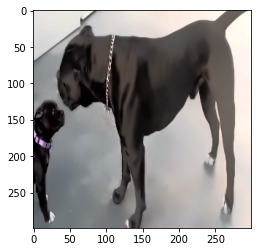

In [23]:
# Show exemple preprocessed image
plt.imshow(image.array_to_img(X[221]))

#Mô hình CNN
#Chuẩn bị dữ liệu cho mô hình CNN


In [24]:
# Using np.shuffle
img_space = np.arange(X.shape[0])
np.random.seed(8)
# Shuffle the space
np.random.shuffle(img_space)
# Apply to X and y in same order
X = X[img_space]
y = y[img_space]

In [25]:
# Change X type 
X = X.astype(np.float32)
# Encode y text data in numeric
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [26]:
# Verifie encoder created classes
print(encoder.classes_)

['Affenhuahua dog' 'Afgan Hound dog' 'Akita dog' 'Alaskan Malamute dog'
 'American Bulldog dog' 'Auggie dog' 'Beagle dog' 'Belgian Tervuren dog'
 'Bichon Frise dog' 'Bocker dog' 'Borzoi dog' 'Boxer dog' 'Bugg dog'
 'Rhodesian_ridgeback']


#Chia dữ liệu thành 8-2

In [27]:
### Create train and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("-" * 50)
print("Size of created sets :")
print("-" * 50)
print("Train set size = ",x_train.shape[0])
print("Test set size = ",x_test.shape[0])

--------------------------------------------------
Size of created sets :
--------------------------------------------------
Train set size =  655
Test set size =  164


In [28]:
# Data generator on train set with Data Augmentation
# Validation set is define here
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(rescale=1./255)

# Xây dựng mô hình CNN

In [29]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

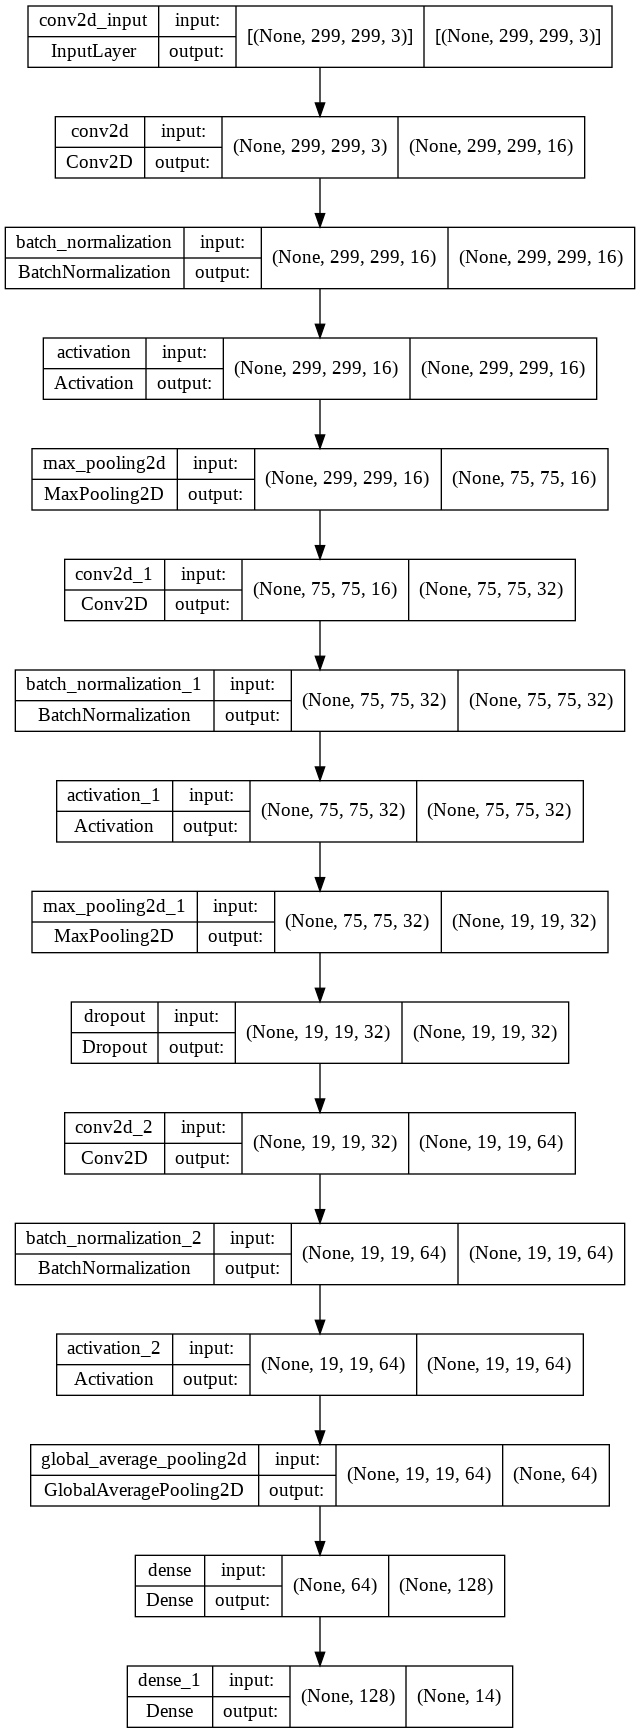

In [30]:
K.clear_session()
model = Sequential()
# Convolution layer
model.add(Conv2D(filters=16,
                 kernel_size=(3,3), 
                 padding='same',
                 use_bias=False,
                 input_shape=(299,299,3)))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
# Pooling layer
model.add(MaxPooling2D(pool_size=(4, 4),
                       strides=(4, 4),
                       padding='same'))
# Second convolution layer
model.add(Conv2D(filters=32,
                 kernel_size=(3,3), 
                 padding='same',
                 use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# Third convolution layer
model.add(Conv2D(filters=64,
                 kernel_size=(3,3), 
                 padding='same',
                 use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
model.add(GlobalAveragePooling2D())
# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(num_breeds, activation='softmax'))
plot_model(model, to_file='CNN_model_plot.png', 
           show_shapes=True, show_layer_names=True)

In [31]:
# Compile the CNN Model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", f1_m])

# Train và đánh giá mô hình CNN

In [32]:
history = model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=20,
    verbose=2)

Epoch 1/20
20/20 - 20s - loss: 2.5101 - accuracy: 0.2054 - f1_m: 13.6485 - val_loss: 2.6004 - val_accuracy: 0.2137 - val_f1_m: 16.5602 - 20s/epoch - 996ms/step
Epoch 2/20
20/20 - 8s - loss: 2.4584 - accuracy: 0.2351 - f1_m: 10.6819 - val_loss: 2.6294 - val_accuracy: 0.0458 - val_f1_m: 15.9763 - 8s/epoch - 395ms/step
Epoch 3/20
20/20 - 8s - loss: 2.3944 - accuracy: 0.2741 - f1_m: 13.1395 - val_loss: 2.6486 - val_accuracy: 0.0458 - val_f1_m: 16.8632 - 8s/epoch - 407ms/step
Epoch 4/20
20/20 - 8s - loss: 2.4421 - accuracy: 0.2259 - f1_m: 11.4238 - val_loss: 2.7280 - val_accuracy: 0.0458 - val_f1_m: 15.5220 - 8s/epoch - 390ms/step
Epoch 5/20
20/20 - 8s - loss: 2.4220 - accuracy: 0.2410 - f1_m: 12.9793 - val_loss: 2.8413 - val_accuracy: 0.0458 - val_f1_m: 13.3278 - 8s/epoch - 391ms/step
Epoch 6/20
20/20 - 8s - loss: 2.3228 - accuracy: 0.2827 - f1_m: 10.9292 - val_loss: 2.9986 - val_accuracy: 0.0458 - val_f1_m: 10.6361 - 8s/epoch - 396ms/step
Epoch 7/20
20/20 - 8s - loss: 2.3705 - accuracy: 0

In [33]:
def plot_history_scores(dict_history, first_score, second_score):
    with plt.style.context('seaborn-whitegrid'):
        fig = plt.figure(figsize=(25,10))
        # summarize history for accuracy
        plt.subplot(1, 2, 1)
        plt.plot(dict_history.history[first_score], color="g")
        plt.plot(dict_history.history['val_' + first_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + first_score, fontsize=18)
        plt.ylabel(first_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        # summarize history for loss
        plt.subplot(1, 2, 2)
        plt.plot(dict_history.history[second_score], color="g")
        plt.plot(dict_history.history['val_' + second_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + second_score, fontsize=18)
        plt.ylabel(second_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

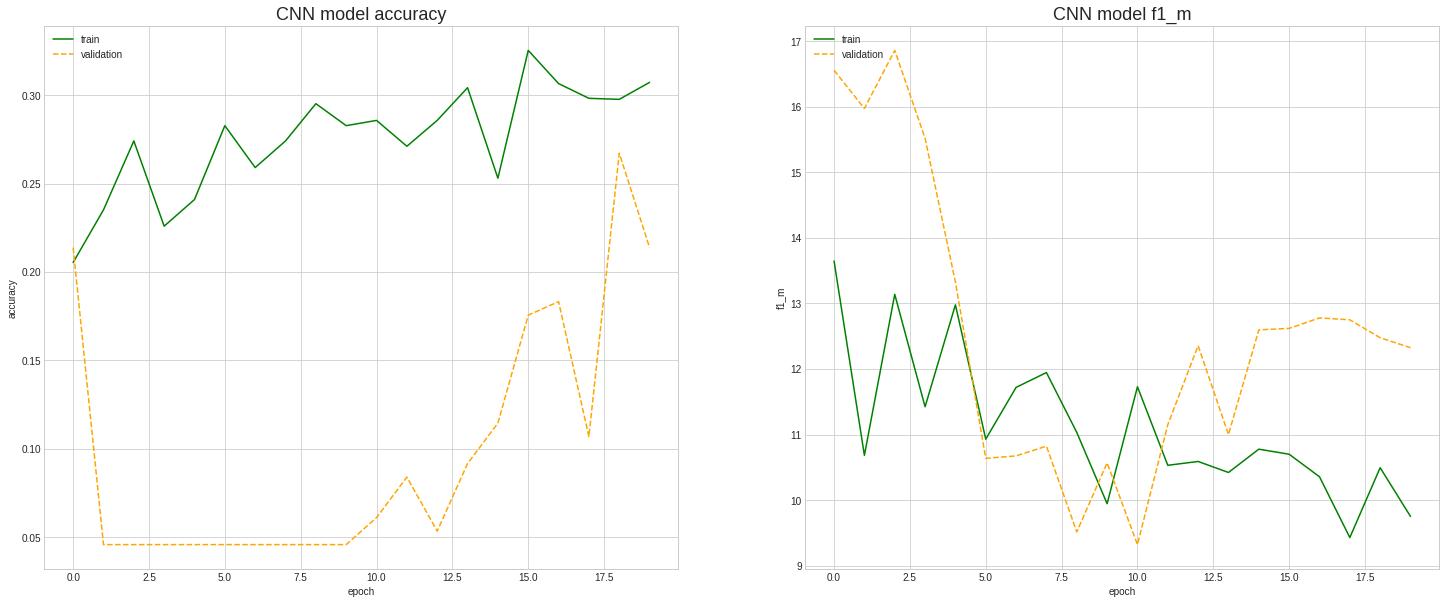

In [34]:
plot_history_scores(
    dict_history = history, 
    first_score = "accuracy", 
    second_score = "f1_m")

# Chuyển giao mô hình sang: Xception và CNN được đào tạo trước
# Nhập mô hình Xception được train trước

In [35]:
K.clear_session()
# Import Xception trained model
xception_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(299,299,3))

# look at the differents layers
print("-" * 50)
print("Xception base model layers :")
print("-" * 50)
for layer in xception_model.layers:
    print(layer)

83697664/83683744 [==============================] - 1s 0us/step
--------------------------------------------------
Xception base model layers :
--------------------------------------------------


# Đào tạo trình phân loại mới trên Xception

In [36]:
for layer in xception_model.layers:
    layer.trainable = False

In [37]:
# Add new fully-connected layers
base_output = xception_model.output
base_output = Dense(128, activation='relu')(base_output)
base_output = Dropout(0.2)(base_output)
# Output : new classifier
predictions = Dense(num_breeds, activation='softmax')(base_output)

# Define new model
my_xcept_model = Model(inputs=xception_model.input,
                       outputs=predictions)
my_xcept_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy", f1_m])

In [38]:
Xception_plot = plot_model(my_xcept_model,
                           to_file='xcept_model_plot.png',
                           show_shapes=True,
                           show_layer_names=False)

In [39]:
# Data generator on train set with Data Augmentation
# and preprocess_input Xception
# Validation set is define here
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [40]:
history_xcept = my_xcept_model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=20,
    verbose=2)

Epoch 1/20
20/20 - 16s - loss: 2.4306 - accuracy: 0.2410 - f1_m: 9.6120 - val_loss: 2.2885 - val_accuracy: 0.3053 - val_f1_m: 9.7959 - 16s/epoch - 762ms/step
Epoch 2/20
20/20 - 13s - loss: 1.9678 - accuracy: 0.4315 - f1_m: 7.5502 - val_loss: 1.9164 - val_accuracy: 0.4351 - val_f1_m: 5.7909 - 13s/epoch - 647ms/step
Epoch 3/20
20/20 - 9s - loss: 1.7810 - accuracy: 0.4554 - f1_m: 5.9185 - val_loss: 1.6874 - val_accuracy: 0.4733 - val_f1_m: 5.3053 - 9s/epoch - 453ms/step
Epoch 4/20
20/20 - 9s - loss: 1.5560 - accuracy: 0.5271 - f1_m: 5.6522 - val_loss: 1.4863 - val_accuracy: 0.6336 - val_f1_m: 4.9666 - 9s/epoch - 447ms/step
Epoch 5/20
20/20 - 9s - loss: 1.3806 - accuracy: 0.6131 - f1_m: 4.4214 - val_loss: 1.3996 - val_accuracy: 0.5878 - val_f1_m: 4.8150 - 9s/epoch - 451ms/step
Epoch 6/20
20/20 - 9s - loss: 1.2914 - accuracy: 0.6024 - f1_m: 4.3566 - val_loss: 1.4031 - val_accuracy: 0.5878 - val_f1_m: 4.2792 - 9s/epoch - 453ms/step
Epoch 7/20
20/20 - 9s - loss: 1.1858 - accuracy: 0.6747 - f1

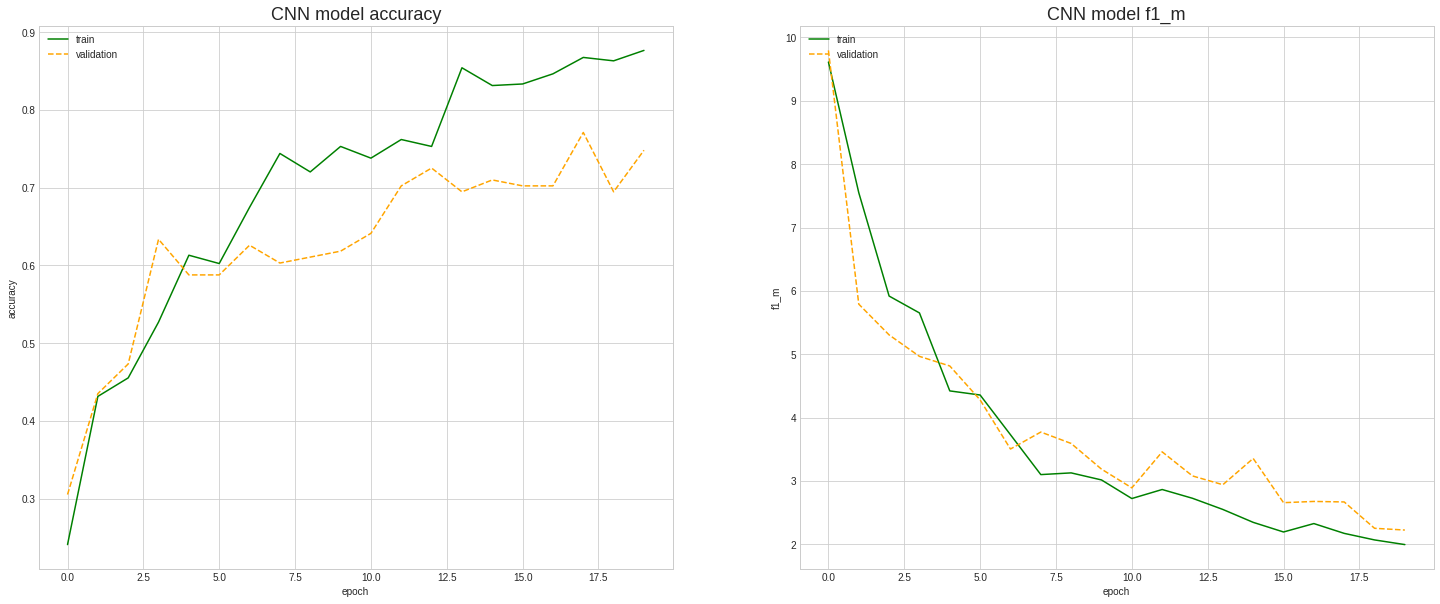

In [41]:
plot_history_scores(
    dict_history = history_xcept, 
    first_score = "accuracy", 
    second_score = "f1_m")

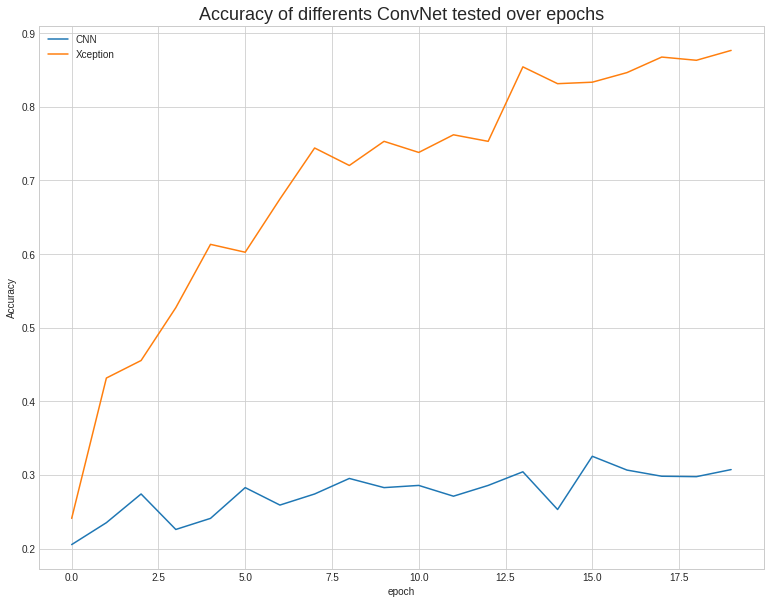

In [42]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13,10))
    plt.plot(history.history['accuracy'],
             label='CNN')
    plt.plot(history_xcept.history['accuracy'],
             label='Xception')
    plt.title('Accuracy of differents ConvNet tested over epochs',
              fontsize=18)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

In [43]:
xcept_mean_accuracy = np.mean(history_xcept.history['val_accuracy'])
xcept_mean_f1 = np.mean(history_xcept.history['val_f1_m'])
print("-" * 50)
print("Xception base model validation Scores :")
print("-" * 50)
print("Mean validation accuracy: {:.2f}"\
      .format(xcept_mean_accuracy))
print("Mean validation F1 score: {:.2f}"\
      .format(xcept_mean_f1))

--------------------------------------------------
Xception base model validation Scores :
--------------------------------------------------
Mean validation accuracy: 0.63
Mean validation F1 score: 3.86


# So sánh với mô hình ResNet50

In [44]:
K.clear_session()
# Import ResNet50 trained model
resnet_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(299,299,3))

# Dont retrain layers
for rn_layer in resnet_model.layers:
    rn_layer.trainable = False
    
# Add new fully-connected layers
rn_base_output = resnet_model.output
rn_base_output = Dense(128, activation='relu')(rn_base_output)
rn_base_output = Dropout(0.2)(rn_base_output)
# Output : new classifier
rn_predictions = Dense(num_breeds, activation='softmax')(rn_base_output)

# Define new model
my_resnet_model = Model(inputs=resnet_model.input,
                        outputs=rn_predictions)
my_resnet_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy", f1_m])

# Data generator on train set with Data Augmentation
# and preprocess_input Resnet
# Validation set is define here
rn_train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.resnet.preprocess_input)

#For validation and test, just rescale
rn_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input)

94781440/94765736 [==============================] - 1s 0us/step


In [45]:
history_resnet = my_resnet_model.fit(
    rn_train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=rn_train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=20,
    verbose=2)

Epoch 1/20
20/20 - 15s - loss: 2.6739 - accuracy: 0.2651 - f1_m: 7.2357 - val_loss: 2.2359 - val_accuracy: 0.3053 - val_f1_m: 6.3365 - 15s/epoch - 748ms/step
Epoch 2/20
20/20 - 9s - loss: 2.0438 - accuracy: 0.3765 - f1_m: 6.8791 - val_loss: 2.0328 - val_accuracy: 0.3740 - val_f1_m: 5.8628 - 9s/epoch - 445ms/step
Epoch 3/20
20/20 - 9s - loss: 1.8848 - accuracy: 0.3899 - f1_m: 6.4054 - val_loss: 2.0167 - val_accuracy: 0.3969 - val_f1_m: 4.6647 - 9s/epoch - 445ms/step
Epoch 4/20
20/20 - 9s - loss: 1.6732 - accuracy: 0.4821 - f1_m: 5.3421 - val_loss: 1.8351 - val_accuracy: 0.4122 - val_f1_m: 5.4296 - 9s/epoch - 440ms/step
Epoch 5/20
20/20 - 10s - loss: 1.4442 - accuracy: 0.5685 - f1_m: 4.6629 - val_loss: 1.6205 - val_accuracy: 0.5420 - val_f1_m: 6.1704 - 10s/epoch - 506ms/step
Epoch 6/20
20/20 - 9s - loss: 1.3453 - accuracy: 0.5863 - f1_m: 4.6250 - val_loss: 1.4856 - val_accuracy: 0.5420 - val_f1_m: 5.2509 - 9s/epoch - 438ms/step
Epoch 7/20
20/20 - 9s - loss: 1.2228 - accuracy: 0.6280 - f1

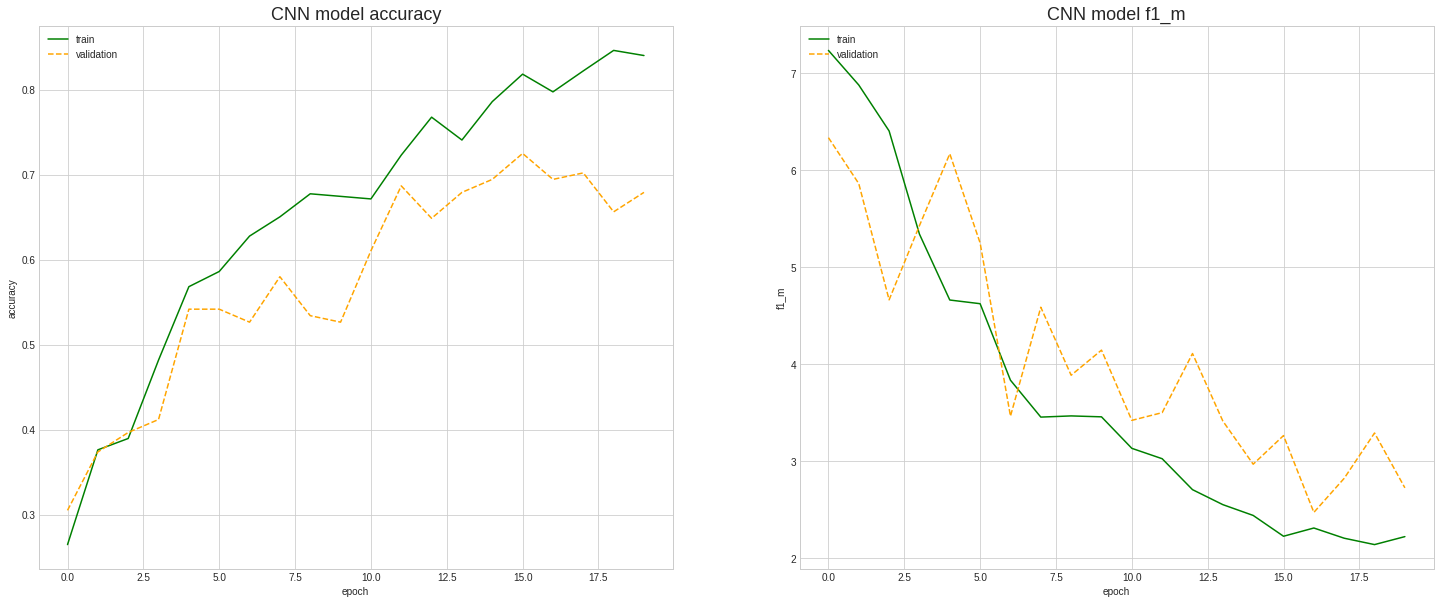

In [46]:
plot_history_scores(
    dict_history = history_resnet, 
    first_score = "accuracy", 
    second_score = "f1_m")


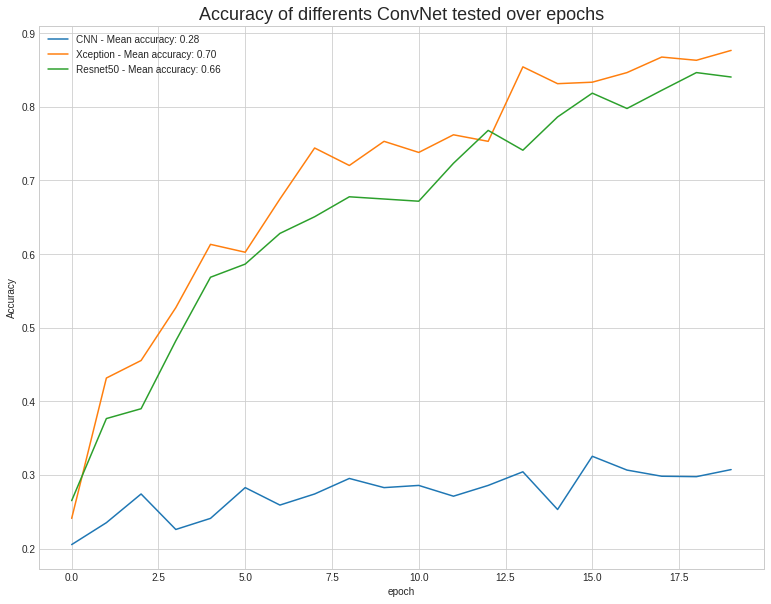

In [47]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13,10))
    plt.plot(history.history['accuracy'],
             label='CNN - Mean accuracy: {:.2f}'.format(
                 np.mean(history.history['accuracy'])))
    plt.plot(history_xcept.history['accuracy'],
             label='Xception - Mean accuracy: {:.2f}'.format(
                 np.mean(history_xcept.history['accuracy'])))
    plt.plot(history_resnet.history['accuracy'],
             label='Resnet50 - Mean accuracy: {:.2f}'.format(
                 np.mean(history_resnet.history['accuracy'])))
    plt.title('Accuracy of differents ConvNet tested over epochs',
              fontsize=18)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

# Tối ưu hóa các tham số trên lớp phân loại của mô hình Xception

In [48]:
def model_builder(hp):
    # Load base model
    xception_model = tf.keras.applications.xception.Xception(
        weights='imagenet',
        include_top=False,
        pooling='avg',
        input_shape=(299,299,3))
    
    for layer in xception_model.layers:
        layer.trainable = False
    
    base_output = xception_model.output
    
    # Tune dense units
    hp_units = hp.Int('dense_units',
                      min_value=32,
                      max_value=300,
                      step=32,
                      default=128)

    base_output = Dense(units=hp_units, 
                        activation='relu')(base_output)
    
    base_output = Dropout(0.2)(base_output)
    
    # Output : new classifier
    predictions = Dense(num_breeds, activation='softmax')(base_output)

    # Define new model
    my_xcept_model = Model(inputs=xception_model.input,
                       outputs=predictions)
    
    # Tune learning rate
    hp_learning_rate = hp.Choice(
        name='learning_rate',
        values=[1e-2, 1e-3, 1e-4])

    my_xcept_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", f1_m])
    
    return my_xcept_model

In [49]:
# Tune the learning rate for the optimizer
# Constuct the tuner of kerastuner
tuner = kt.RandomSearch(
    model_builder, 
    objective='val_accuracy',
    max_trials=5)

# Define a early stopping
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5)

# Search best params
tuner.search(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    epochs=10,
    callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("-" * 50)
print("Xception Hyperparameters optimization :")
print("-" * 50)
print(f"""
Best learning rate : {best_hps.get('learning_rate')}.\n
Best Dense units : {best_hps.get('dense_units')}.""")

Trial 5 Complete [00h 02m 20s]
val_accuracy: 0.7557252049446106

Best val_accuracy So Far: 0.7557252049446106
Total elapsed time: 00h 11m 55s
--------------------------------------------------
Xception Hyperparameters optimization :
--------------------------------------------------

Best learning rate : 0.001.

Best Dense units : 192.


In [50]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'), 
    epochs=30,
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    verbose=2)
hypermodel.save('xception_hypermodel.h5')
print("Model saved")

Epoch 1/30
33/33 - 18s - loss: 2.2268 - accuracy: 0.3321 - f1_m: 8.9755 - val_loss: 1.8225 - val_accuracy: 0.4580 - val_f1_m: 7.3795 - 18s/epoch - 532ms/step
Epoch 2/30
33/33 - 13s - loss: 1.5940 - accuracy: 0.5229 - f1_m: 5.6200 - val_loss: 1.5376 - val_accuracy: 0.6107 - val_f1_m: 6.9778 - 13s/epoch - 388ms/step
Epoch 3/30
33/33 - 13s - loss: 1.3167 - accuracy: 0.6183 - f1_m: 4.3198 - val_loss: 1.4400 - val_accuracy: 0.5802 - val_f1_m: 3.4422 - 13s/epoch - 387ms/step
Epoch 4/30
33/33 - 13s - loss: 1.1473 - accuracy: 0.6641 - f1_m: 3.5489 - val_loss: 1.3031 - val_accuracy: 0.6336 - val_f1_m: 3.5539 - 13s/epoch - 388ms/step
Epoch 5/30
33/33 - 13s - loss: 1.0110 - accuracy: 0.7023 - f1_m: 3.1805 - val_loss: 1.2158 - val_accuracy: 0.6565 - val_f1_m: 4.0695 - 13s/epoch - 389ms/step
Epoch 6/30
33/33 - 13s - loss: 0.9253 - accuracy: 0.7443 - f1_m: 2.8304 - val_loss: 1.1610 - val_accuracy: 0.6260 - val_f1_m: 3.3664 - 13s/epoch - 387ms/step
Epoch 7/30
33/33 - 14s - loss: 0.7717 - accuracy: 0.

# Tinh chỉnh Xception


In [51]:
def xception_fine_tune(nb_layers):
    # Load the pre trained model
    hypermodel_t = load_model('./xception_hypermodel.h5', custom_objects={"f1_m": f1_m})
    
    # re train the last layers
    for i, layer in enumerate(hypermodel_t.layers):
        if i < nb_layers:
            layer.trainable = False
        else:
            layer.trainable = True
            
    # Compile model
    hypermodel_t.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", f1_m])
    
    return hypermodel_t

In [52]:
# Define a early stopping
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5)

# Dont train the 115 first layers
my_tuned_xcept_model = xception_fine_tune(115)
fine_tuned_history = my_tuned_xcept_model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        shuffle=False,
        subset='training'), 
    epochs=20,
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        shuffle=False,
        subset='validation'),
    callbacks=[stop_early],
    verbose=2)

Epoch 1/20
33/33 - 17s - loss: 1.2266 - accuracy: 0.6202 - f1_m: 3.2884 - val_loss: 4.4171 - val_accuracy: 0.5038 - val_f1_m: 1.3959 - 17s/epoch - 526ms/step
Epoch 2/20
33/33 - 13s - loss: 0.6072 - accuracy: 0.8244 - f1_m: 1.8488 - val_loss: 1.6162 - val_accuracy: 0.6183 - val_f1_m: 2.3933 - 13s/epoch - 403ms/step
Epoch 3/20
33/33 - 15s - loss: 0.3198 - accuracy: 0.9065 - f1_m: 1.4207 - val_loss: 1.9116 - val_accuracy: 0.6183 - val_f1_m: 1.6307 - 15s/epoch - 439ms/step
Epoch 4/20
33/33 - 13s - loss: 0.3288 - accuracy: 0.9065 - f1_m: 1.2686 - val_loss: 2.7809 - val_accuracy: 0.6183 - val_f1_m: 1.5781 - 13s/epoch - 403ms/step
Epoch 5/20
33/33 - 13s - loss: 0.2237 - accuracy: 0.9198 - f1_m: 1.3192 - val_loss: 2.2271 - val_accuracy: 0.6718 - val_f1_m: 1.3583 - 13s/epoch - 400ms/step
Epoch 6/20
33/33 - 13s - loss: 0.1781 - accuracy: 0.9370 - f1_m: 1.1805 - val_loss: 2.1012 - val_accuracy: 0.6870 - val_f1_m: 1.3899 - 13s/epoch - 399ms/step
Epoch 7/20
33/33 - 13s - loss: 0.1554 - accuracy: 0.

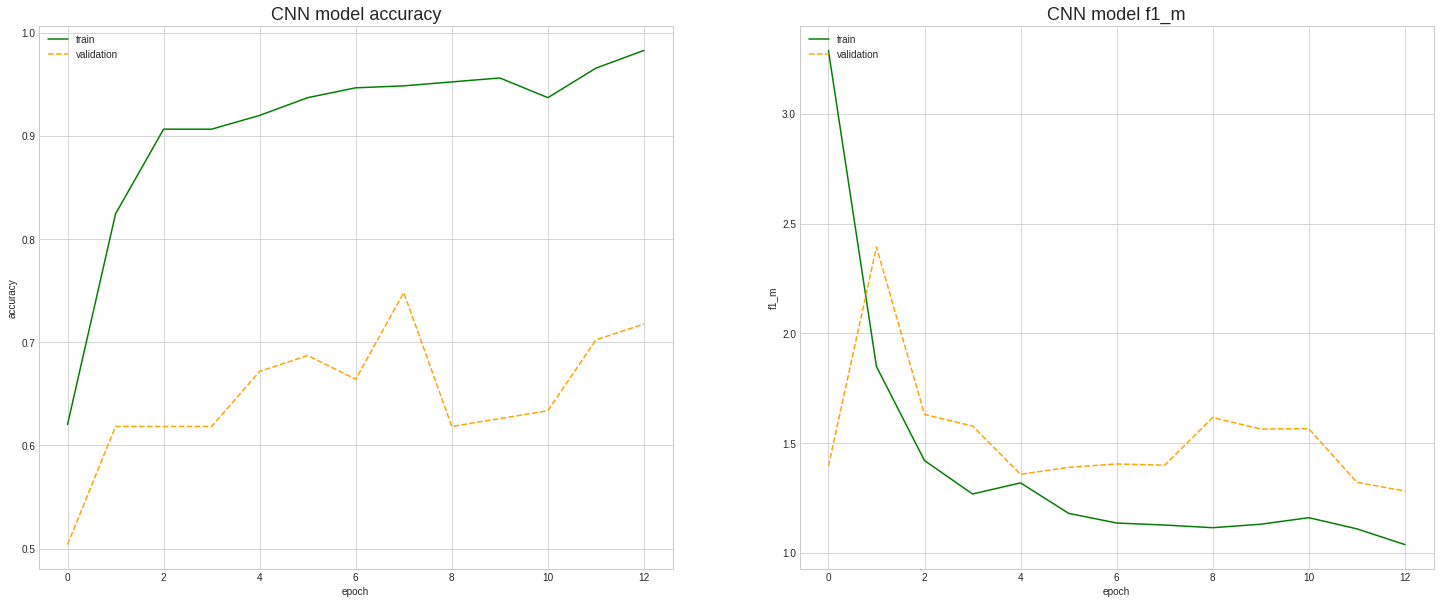

In [53]:
plot_history_scores(
    dict_history = fine_tuned_history, 
    first_score = "accuracy", 
    second_score = "f1_m")

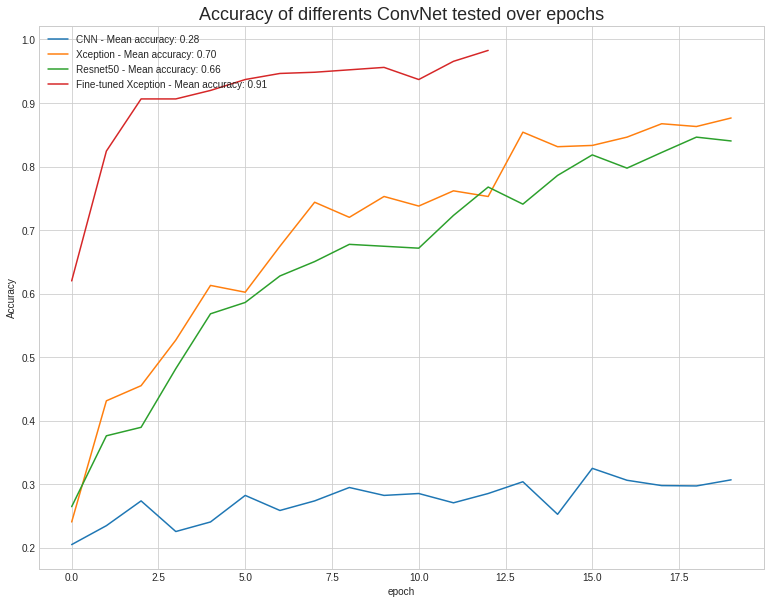

In [54]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13,10))
    plt.plot(history.history['accuracy'],
             label='CNN - Mean accuracy: {:.2f}'.format(
                 np.mean(history.history['accuracy'])))
    plt.plot(history_xcept.history['accuracy'],
             label='Xception - Mean accuracy: {:.2f}'.format(
                 np.mean(history_xcept.history['accuracy'])))
    plt.plot(history_resnet.history['accuracy'],
             label='Resnet50 - Mean accuracy: {:.2f}'.format(
                 np.mean(history_resnet.history['accuracy'])))
    plt.plot(fine_tuned_history.history['accuracy'],
             label='Fine-tuned Xception - Mean accuracy: {:.2f}'.format(
                 np.mean(fine_tuned_history.history['accuracy'])))
    plt.title('Accuracy of differents ConvNet tested over epochs',
              fontsize=18)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

# Đánh giá tinh chỉnh Xception trên dữ liệu thử nghiệm


In [55]:
# Model evaluation on test set
xception_eval = fine_tuned_history.model.evaluate(
    test_datagen.flow(
        x_test, y_test,
        batch_size=16,
        shuffle=False),
    verbose=1)
print("-" * 50)
print("Xception model evaluation :")
print("-" * 50)
print('Test Loss: {:.3f}'.format(xception_eval[0]))
print('Test Accuracy: {:.3f}'.format(xception_eval[1]))
print('Test F1 score: {:.3f}'.format(xception_eval[2]))

11/11 [==============================] - 2s 152ms/step - loss: 2.4496 - accuracy: 0.7805 - f1_m: 1.1677
--------------------------------------------------
Xception model evaluation :
--------------------------------------------------
Test Loss: 2.450
Test Accuracy: 0.780
Test F1 score: 1.168


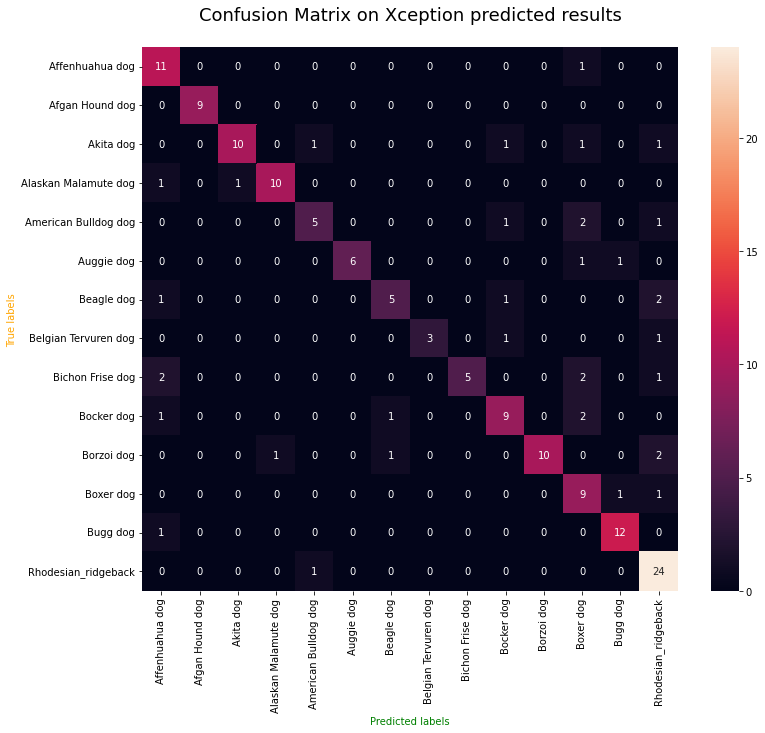

In [56]:
# Make predictions
Y_pred = fine_tuned_history.model.predict(
    test_datagen.flow(
        x_test, y_test,
        batch_size=16,
        shuffle=False))
y_pred = np.argmax(Y_pred, axis=1)

# Inverse transform of encoding
y_pred_s = encoder.inverse_transform(y_pred)
y_test_s = encoder.inverse_transform(y_test)

# Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(12,10))
ax = sns.heatmap(cf_matrix, annot=True)
ax.set_xlabel("Predicted labels", color="g")
ax.set_ylabel("True labels", color="orange")
ax.xaxis.set_ticklabels(encoder.classes_, 
                        rotation='vertical')
ax.yaxis.set_ticklabels(encoder.classes_,
                        rotation='horizontal')
plt.title("Confusion Matrix on Xception predicted results\n",
          fontsize=18)
plt.show()

In [57]:
# Classification report
print(classification_report(
    y_test, y_pred, 
    target_names=sorted(set(y_test_s))))

                      precision    recall  f1-score   support

     Affenhuahua dog       0.65      0.92      0.76        12
     Afgan Hound dog       1.00      1.00      1.00         9
           Akita dog       0.91      0.71      0.80        14
Alaskan Malamute dog       0.91      0.83      0.87        12
American Bulldog dog       0.71      0.56      0.63         9
          Auggie dog       1.00      0.75      0.86         8
          Beagle dog       0.71      0.56      0.63         9
Belgian Tervuren dog       1.00      0.60      0.75         5
    Bichon Frise dog       1.00      0.50      0.67        10
          Bocker dog       0.69      0.69      0.69        13
          Borzoi dog       1.00      0.71      0.83        14
           Boxer dog       0.50      0.82      0.62        11
            Bugg dog       0.86      0.92      0.89        13
 Rhodesian_ridgeback       0.73      0.96      0.83        25

            accuracy                           0.78       164
      

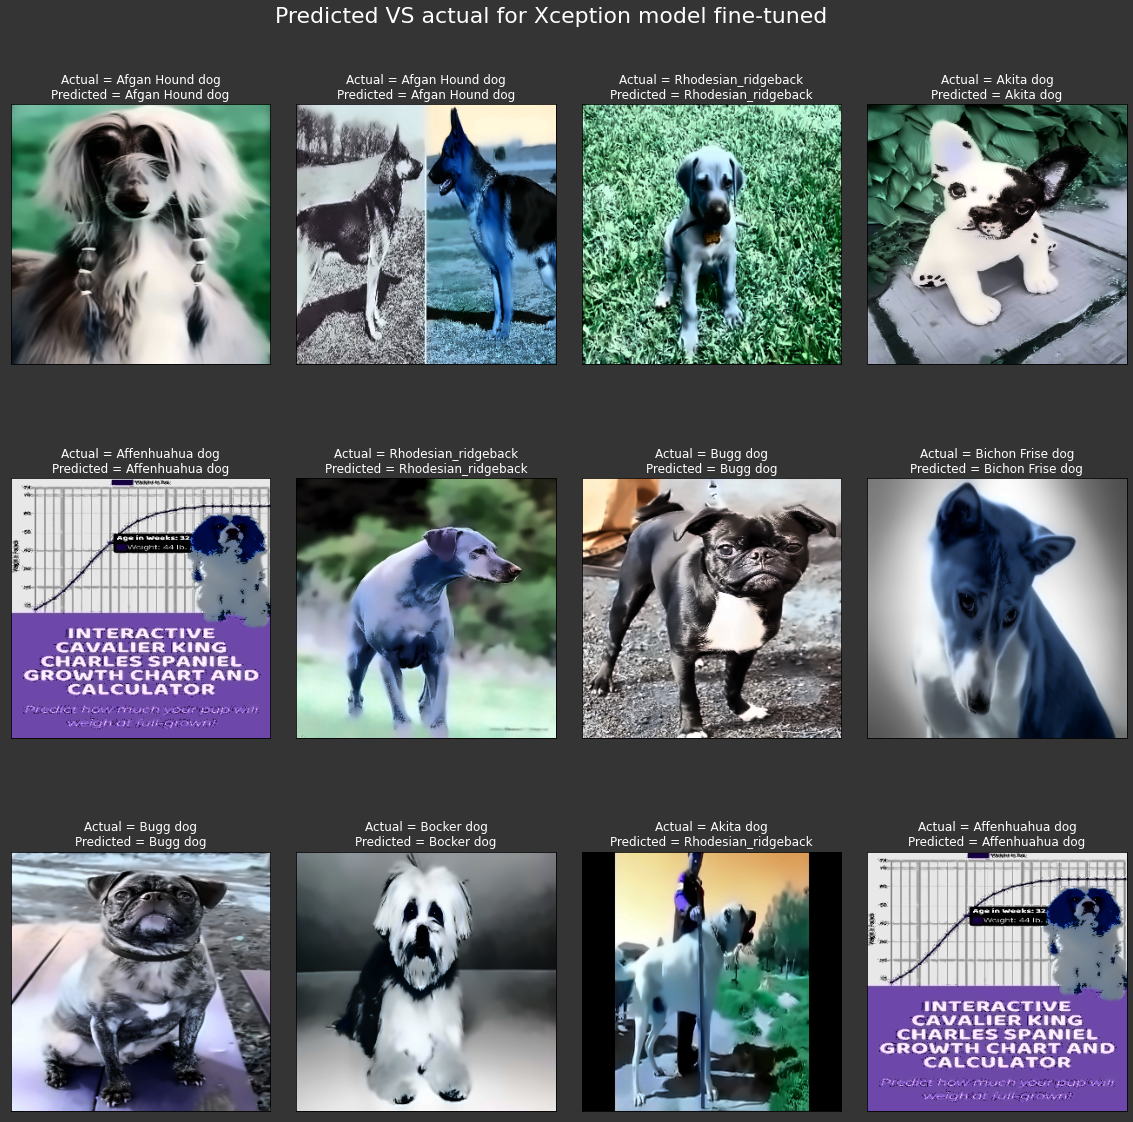

In [58]:
fig = plt.figure(1, figsize=(20,20))
fig.patch.set_facecolor('#343434')
plt.suptitle("Predicted VS actual for Xception model fine-tuned",
             y=.92, fontsize=22,
             color="white")

n = 0

for i in range(12):
    n+=1
    r = int(np.random.randint(0, x_test.shape[0], 1))
    plt.subplot(3,4,n)
    plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
    plt.imshow(image.array_to_img(x_test[r]))
    plt.title('Actual = {}\nPredicted = {}'.format(y_test_s[r] , y_pred_s[r]),
              color="white")
    plt.xticks([]) , plt.yticks([])
    
plt.show()

# Giao diện dự đoán trên dữ liệu mới

In [59]:
# Save the last model
fine_tuned_history.model.save('xception_trained_model.h5')
print("Last model saved")

Last model saved


In [60]:
# Load model
model = load_model('./xception_hypermodel.h5', custom_objects={"f1_m": f1_m})

# Define the full prediction function
def breed_prediction(inp):
    # Convert to RGB
    img = cv.cvtColor(inp,cv.COLOR_BGR2RGB)
    # Resize image
    dim = (299, 299)
    img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
    # Equalization
    img_yuv = cv.cvtColor(img,cv.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
    img_equ = cv.cvtColor(img_yuv, cv.COLOR_YUV2RGB)
    # Apply non-local means filter on test img
    dst_img = cv.fastNlMeansDenoisingColored(
        src=img_equ,
        dst=None,
        h=10,
        hColor=10,
        templateWindowSize=7,
        searchWindowSize=21)

    # Convert modified img to array
    img_array = keras.preprocessing.image.img_to_array(dst_img)
    
    # Apply preprocess Xception
    img_array = img_array.reshape((-1, 299, 299, 3))
    img_array = tf.keras.applications.xception.preprocess_input(img_array)
    
    # Predictions
    prediction = model.predict(img_array).flatten()
    
    #return prediction
    return {encoder.classes_[i]: float(prediction[i]) for i in range(num_breeds)}

# Construct the interface
image = gr.inputs.Image(shape=(299,299))
label = gr.outputs.Label(num_top_classes=3)

gr.Interface(
    fn=breed_prediction,
    inputs=image,
    outputs=label,
    capture_session=True
).launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://49276.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7fb44b2b4f90>,
 'http://127.0.0.1:7860/',
 'https://49276.gradio.app')